<a href="https://colab.research.google.com/github/hertie-data-science-lab/assignment-2-ps-2-e/blob/xiaohan_branch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem set 2

## Team
Please write here your names and team number.

* Team name: ps-2-e
* Team members: Xiaohan Wu


## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [1]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

100%|██████████| 94.3M/94.3M [00:00<00:00, 332MB/s]


The dataset has 27000 images
Picture number 7493 with label: 2


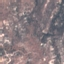

In [2]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

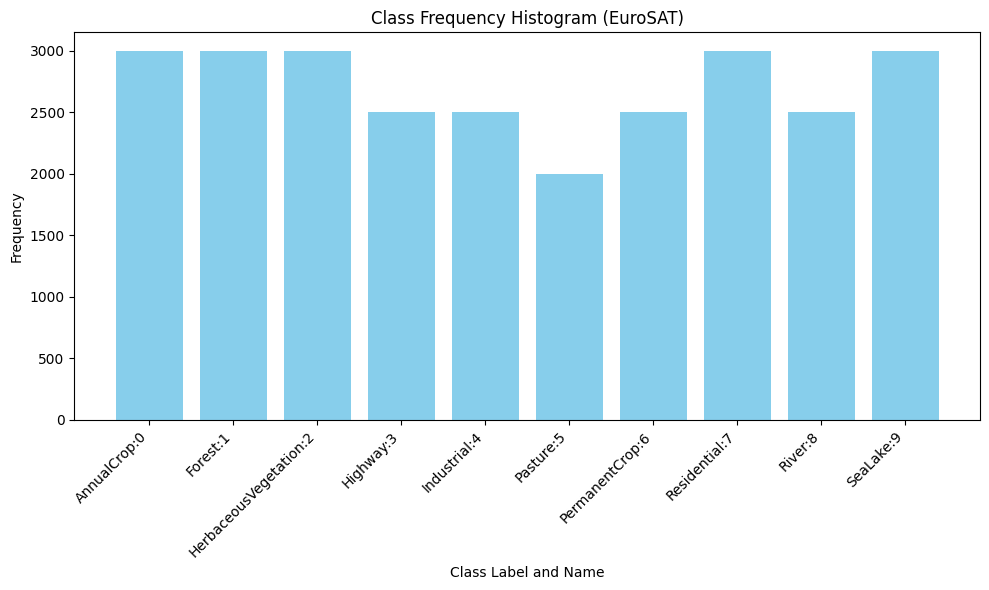

In [3]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

def rotate_picture(picture, rotation):
  '''#TODO: implemented most frequent n people'''
  # PIL uses predefined constants for transpose operations
  if rotation == 90:
    return picture.transpose(Image.ROTATE_90)
  elif rotation == 180:
    return picture.transpose(Image.ROTATE_180)
  elif rotation == 270:
    return picture.transpose(Image.ROTATE_270)
  elif rotation == 360:
    # 360 degrees rotation is no change
    return picture
  else:
    raise ValueError(f"Invalid rotation degree: {rotation}. Must be 90, 180, 270, or 360.")


def plot_histogram(data):
  # extract all labels from the dataset
  labels = [data[i][1] for i in range(len(data))]

  # Count the frequency of each label
  unique_labels, counts = np.unique(labels, return_counts=True)

  try:
    class_names = data.classes
  except AttributeError:
    class_names = [f"Class_{i}" for i in unique_labels]

  # Create labels for the histogram: Name:Label
  x_labels = [f"{class_names[i]}:{i}" for i in unique_labels]

  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the histogram
  ax.bar(x_labels, counts, color='skyblue')

  # Add titles and labels
  ax.set_title("Class Frequency Histogram (EuroSAT)")
  ax.set_xlabel("Class Label and Name")
  ax.set_ylabel("Frequency")
  plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
  plt.tight_layout()

  return fig, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)
fig, ax = plot_histogram(data)
fig.show()

Text(0.5, 1.0, 'Rotated by 360°')

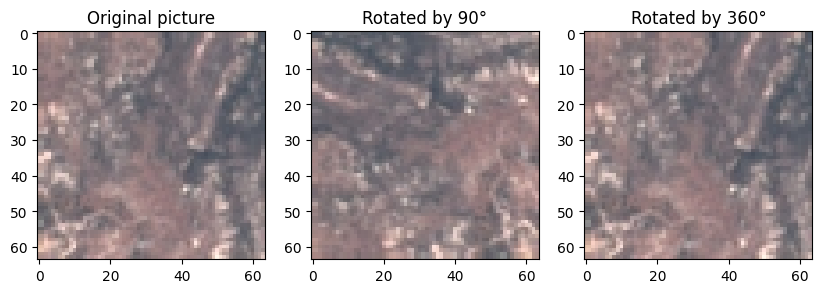

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [5]:
class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data:Dataset,
                 length:int,
                 shares:list,
                 device=None,
                 seed=42):

        self.original_data = original_data
        self.length = length
        assert sum(shares)  == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label

    def _create_rotated_dataset(self):
        """#TODO: implement solution"""
        np.random.seed(self.seed)
        rng = np.random.default_rng(self.seed)

        rotations = [90, 180, 270, 360]
        dataset = []

        # Compute number of samples per class based on shares
        samples_per_class = (np.array(self.shares) * self.length).astype(int)

        # Collect indices by class
        class_indices = {i: [] for i in range(len(self.original_data.classes))}
        for idx in range(len(self.original_data)):
            _, label = self.original_data[idx]
            class_indices[label].append(idx)

        # Build new dataset with rotated images
        for cls, n_samples in enumerate(samples_per_class):
            if n_samples == 0:
                continue

            # Randomly pick indices from this class
            chosen_indices = rng.choice(class_indices[cls], size=n_samples, replace=True)

            for i in chosen_indices:
                pic, label = self.original_data[i]

                # Apply random rotation
                rotation_angle = rng.choice(rotations)
                rotated_pic = rotate_picture(pic, rotation_angle)

                # Convert to tensor if not already
                if not isinstance(rotated_pic, torch.Tensor):
                    rotated_pic = transforms.ToTensor()(rotated_pic)

                # Move to GPU if specified
                if self.device:
                    rotated_pic = rotated_pic.to(self.device)

                dataset.append((rotated_pic, label))

        return dataset

In [6]:
rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             seed=42)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyMaxPool(nn.Sequential):

  def __init__(self,
               kernel_size,
               stride=1,
               padding=0):

    super().__init__()
    self.kernel_size = kernel_size
    self.stride = stride if stride else kernel_size
    self.padding = padding


  def forward(self, x):
    # Use PyTorch functional API for pooling
    return F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)


class MyCNNModel(nn.Sequential):

  def __init__(self,
               n_classes):

    super().__init__()

    #convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.pool = MyMaxPool(kernel_size=2, stride=2) #pooling layer

    # Flatten and fully connected linear layers
    self.fc1 = nn.Linear(128 * 8 * 8, 256)
    self.fc2 = nn.Linear(256, n_classes)

    self.relu = nn.ReLU()


  def forward(self, x):
    # Convolution + Activation + Pooling layers
    x = self.relu(self.conv1(x))
    x = self.pool(x)

    x = self.relu(self.conv2(x))
    x = self.pool(x)

    x = self.relu(self.conv3(x))
    x = self.pool(x)

    # Flatten
    x = torch.flatten(x, 1)

    # Fully connected layers
    x = self.relu(self.fc1(x))
    x = self.fc2(x)

    return x



In [14]:
'''#TODO: print one iteration of your model to test its correctness'''
my_model = MyCNNModel(n_classes=10)
X, y = train_data[0]
my_model(X[None, :])

tensor([[ 0.0359, -0.0156, -0.0462, -0.0264, -0.0274, -0.0039,  0.0296, -0.0587,
          0.0404, -0.0587]], grad_fn=<AddmmBackward0>)

Rationale:

The CNN consists of three convolutional layers with increasing channel depth (32, 64, 128) and alternating kernel sizes (3x3 and 5x5) to capture both fine and coarse spatial features. Each convolution is followed by ReLU and max pooling to introduce non-linearity and reduce spatial dimensions. The fully connected layers map learned features to the final class probabilities.

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [12]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc

Epoch:0 - Avg loss:1.53919 - Avg acc:0.41016: 100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Text(0.5, 1.0, 'Training accuracy')

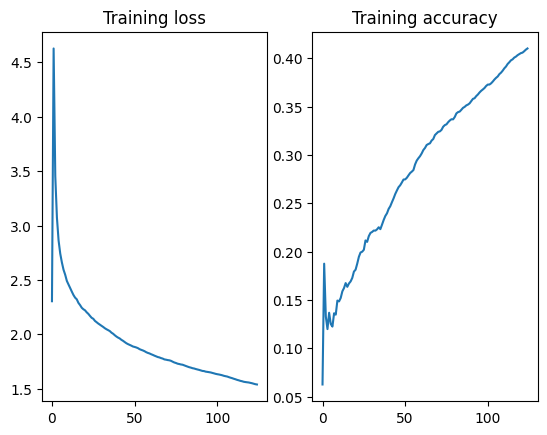

In [15]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

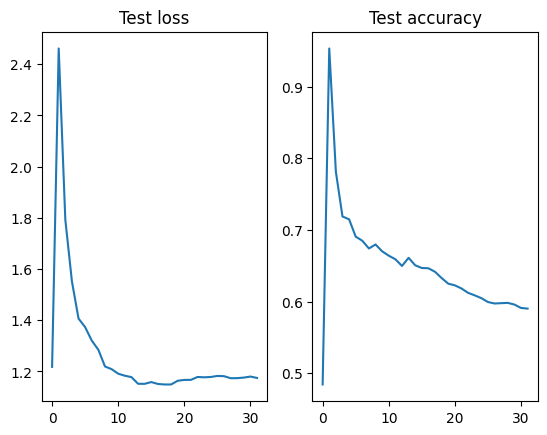

In [16]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [17]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    best_model = None
    best_cfg = None
    best_avg_acc = 0.0
    best_avg_loss = float('inf')

    # Try all learning rates and batch sizes
    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\nTraining with learning rate={lr}, batch size={bs}")

            # Copy base configuration and update the current ones
            current_cfg = cfg.copy()
            current_cfg['learning_rate'] = lr
            current_cfg['batch_size'] = bs

            # Initialize a new model and trainer
            model = MyCNNModel(n_classes=10)   # <-- Use your correct number of classes
            trainer = Trainer(model, current_cfg)

            # Train the model
            avg_loss, avg_acc = trainer.train(train_dataset)

            # Compute final averages over iterations
            with torch.no_grad():
              final_loss = np.mean(avg_loss[-min(10, len(avg_loss)):])
              final_acc = np.mean(avg_acc[-min(10, len(avg_acc)):])

            print(f"  → Final avg loss: {final_loss:.4f}, avg acc: {final_acc:.4f}")

            # Keep best model (based on accuracy)
            if final_acc > best_avg_acc or (final_acc == best_avg_acc and final_loss < best_avg_loss):
                best_model = model
                best_cfg = current_cfg
                best_avg_loss = final_loss
                best_avg_acc = final_acc

    print("\n=== Best Configuration Found ===")
    print(f"Learning Rate: {best_cfg['learning_rate']}, Batch Size: {best_cfg['batch_size']}")
    print(f"Avg Loss: {best_avg_loss:.4f}, Avg Accuracy: {best_avg_acc:.4f}")

    return best_model, best_cfg, best_avg_loss, best_avg_acc

best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")



Training with learning rate=0.1, batch size=32


Epoch:0 - Avg loss:1045.37627 - Avg acc:0.09752: 100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


  → Final avg loss: 1064.7205, avg acc: 0.0974

Training with learning rate=0.1, batch size=64


Epoch:0 - Avg loss:2511.67782 - Avg acc:0.10383: 100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


  → Final avg loss: 2607.6786, avg acc: 0.1040

Training with learning rate=0.1, batch size=128


Epoch:0 - Avg loss:2865.85982 - Avg acc:0.09892: 100%|██████████| 63/63 [01:18<00:00,  1.24s/it]


  → Final avg loss: 3097.7023, avg acc: 0.0991

Training with learning rate=0.01, batch size=32


Epoch:0 - Avg loss:1.92592 - Avg acc:0.28803: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]


  → Final avg loss: 1.9332, avg acc: 0.2855

Training with learning rate=0.01, batch size=64


Epoch:0 - Avg loss:2.28383 - Avg acc:0.23034: 100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


  → Final avg loss: 2.3049, avg acc: 0.2286

Training with learning rate=0.01, batch size=128


Epoch:0 - Avg loss:2.75339 - Avg acc:0.10232: 100%|██████████| 63/63 [01:17<00:00,  1.23s/it]


  → Final avg loss: 2.7897, avg acc: 0.1032

Training with learning rate=0.001, batch size=32


Epoch:0 - Avg loss:1.47309 - Avg acc:0.43675: 100%|██████████| 250/250 [01:11<00:00,  3.50it/s]


  → Final avg loss: 1.4800, avg acc: 0.4339

Training with learning rate=0.001, batch size=64


Epoch:0 - Avg loss:1.53919 - Avg acc:0.41016: 100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


  → Final avg loss: 1.5544, avg acc: 0.4046

Training with learning rate=0.001, batch size=128


Epoch:0 - Avg loss:1.69048 - Avg acc:0.35610: 100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  → Final avg loss: 1.7095, avg acc: 0.3518

=== Best Configuration Found ===
Learning Rate: 0.001, Batch Size: 32
Avg Loss: 1.4800, Avg Accuracy: 0.4339
Best model achieves 1.48 loss and 43.4% accuracy


## Task 4: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [26]:
import timm  # pretrained models from Hugging Face / PyTorch Image Models
import torch.nn as nn
import torch

'''#TODO: import and fine-tune a pretrained model'''

# Load a small, efficient pretrained model (good for Colab GPU memory)
loaded_model = timm.create_model("resnet18", pretrained=True)

# Reset its final classification layer to match our 10 EuroSAT classes
num_features = loaded_model.get_classifier().in_features
loaded_model.reset_classifier(num_classes=10)

# Freeze early layers (transfer learning: keep pretrained weights)
for name, param in loaded_model.named_parameters():
    if "layer4" in name or "fc" in name:   # fine-tune only the last block and classifier
        param.requires_grad = True
    else:
        param.requires_grad = False

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = loaded_model.to(device)

# Create a trainer using the same configuration
loaded_trainer = Trainer(loaded_model, cfg)

In [27]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

  0%|          | 0/125 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Epoch:0 - Avg loss:0.17302 - Avg acc:0.95665: 100%|██████████| 125/125 [00:02<00:00, 59.14it/s]


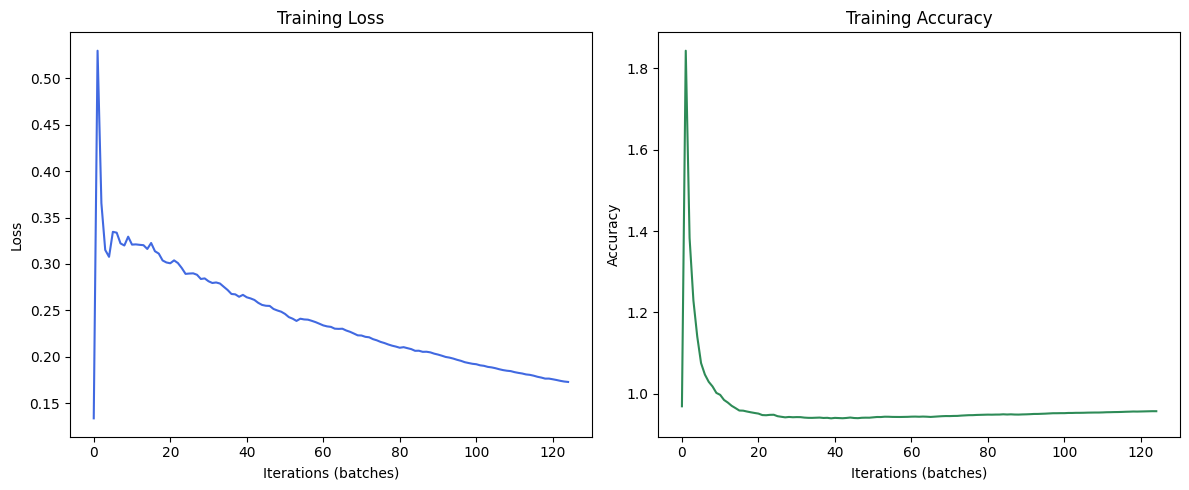

In [19]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''

train_loss, train_acc = loaded_trainer.train(train_data)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
ax0.plot(range(len(train_loss)), train_loss, color='royalblue')
ax1.plot(range(len(train_acc)), train_acc, color='seagreen')

ax0.set_title('Training Loss')
ax1.set_title('Training Accuracy')
ax0.set_xlabel('Iterations (batches)')
ax1.set_xlabel('Iterations (batches)')
ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

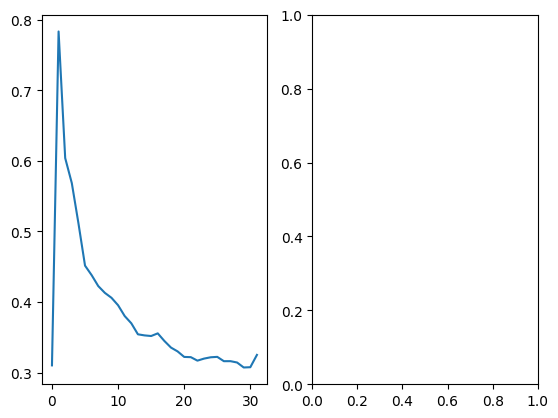

In [20]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

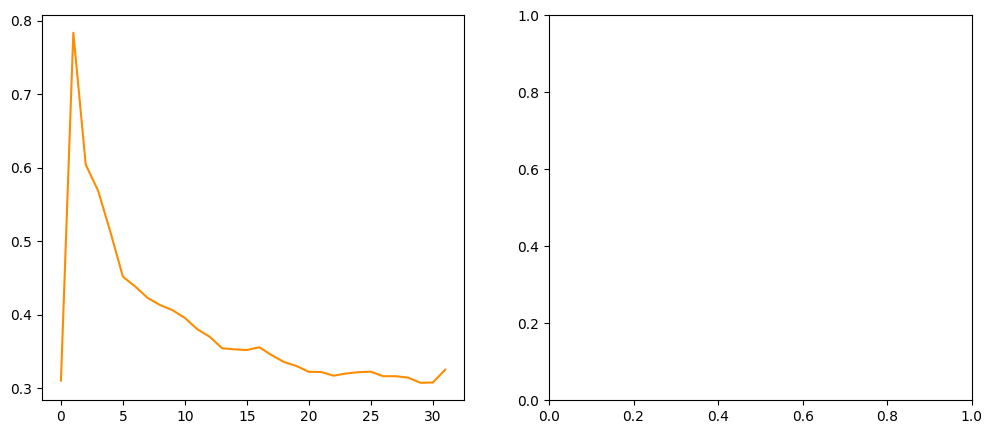

In [21]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''

test_loss, test_acc = loaded_trainer.test(test_data)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
ax0.plot(range(len(test_loss)), test_loss, color='darkorange')
ax1.plot(range(len(test_acc)), test_acc, color='firebrick')

ax0.set_title('Test Loss')
ax1.set_title('Test Accuracy')
ax0.set_xlabel('Iterations (batches)')
ax1.set_xlabel('Iterations (batches)')
ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

print("\n=== Fine-tuning Summary ===")
print(f"Final Training Accuracy: {train_acc[-1]*100:.2f}%")
print(f"Final Test Accuracy: {test_acc[-1]*100:.2f}%")

<a name="results-and-discussion"></a>
# Task  5: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             



